# Stochastic Optimization - Implementation project

Supervised by: Prof. Olivier FERCOQ

---

In this project, we are implementing an Image Classifier where the goal is to classify digits between 0 and 9 using two algorithms which we have learned during the class, the first algorithm is stochastic gradient descent and the second one is Adam , it is important to emphasize on the main difference between these two algorithms: that the SGD has a deterministic step size but Adam has an adaptive step sizes.

### Basic Remarks
* we used the **MNIST** database available on their website http://yann.lecun.com/exdb/mnist/

        The MNIST database of handwritten numbers, contains a training set of 60,000 examples and a test set of 10,000 examples.
        (we split the 60000 to 10% for validation and the rest for training data)

* we have imported the data from keras.datasets as it is availablwe there
* We are dealing with **Supervised Learning**, we have the pictures as well as their labels.
* we used the **Multinomial logisitic regression with squared 2-norm regularization** model, where the objective function is the convex function:- 
$$F_\alpha (w) = \frac{1}{n_{train}} \sum_{i = 1}^{n_{train}} \log~(\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j}))-\sum_{j = 0}^{9} y_{i,j}(\sum_{k = 1}^{d} x_{i,k}w_{k,j} ) + \frac{\alpha}{2} \|w\|^2_2$$
Where, 
1. $x_i$ is an image in the training dataset.
1. $n$ is the number of images in the training dataset.
2. $d$ is the number of pixels in the image $x_i$.
3. $y_{i,j} = \begin{cases} 1 & \text{if the image} ~i~ \text{represents digit}~ j \\ 0 & \text{otherwise}\end{cases}$
4. $\alpha \in \mathbb{R}^+$
5. The last term is a regularizer (differentiable) and to overcome overfitting as we will tune it using validation set.

### why we use "Stochastic Algorithms"?

Since our objective function that we want to minimize can be written as a finite sum
$$F(w) = \frac{1}{n} \sum_{i = 1}^{n} F_i(w)$$ 
Where, $~\forall i \in \{1,\dots \dots, n\}$
$$F_i(w) = \log~(\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} )) - \sum_{j = 0}^{9} y_{i,j}(\sum_{k = 1}^{d} x_{i,k}w_{k,j}) + \frac{\alpha}{2} \|w\|^2_2$$

Then, from what we learnt that in all the stochastic algorithms (SGD, SVRG, Adagrad and ADAM) that at each iteration we just need the gradient of $F_i$ respect to $w$ for some **random** $i$ instead of the gradient of $F$ for all i.
I mean computing the gradient costs high , so the advantage of stochastic algorithms is reducing the cost by taking a smaller number of data that we need to implement the algorithm and converge to the optimal solution.

# Importing the Libraries:

In [1]:
import numpy as np                                       #to deal with matricies and arrays 
import random                                            #to generate random value
import matplotlib.pyplot as plt                          #to do the plots 
import tensorflow as tf                                  #to import the data 
from tensorflow import keras
from sklearn.model_selection import train_test_split     #to split the Data 
from numpy import array  
from numpy.linalg import norm                            #to use the norm
from sklearn.preprocessing import OneHotEncoder          #For One hot encoding to Labels
import time

#  Import the Dataset 

In [2]:
# Read the Dataset from MNIST using tenserflow & keras 
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")

#number of testing data = 10,000 
# Number of images in the traning dataset (60,000)
# Split the Train Dataset to train and validation
#number of training data = 0.9 * 60,000 = 54,000 
#number of validation data = 0.1 * 60,000 = 6,000         

x_train, x_validate, y_train, y_validate = train_test_split(train_data[0], train_data[1] , test_size=0.1)

# The dimesnion of any image in the training dataset   (28 x 28)
# reshape the the images to be a vector of pixels for each image and normalize

x_train = x_train.reshape(-1,784).astype(float) / 255        
x_validate = x_validate.reshape(-1,784).astype(float) / 255

#to define test set and labels
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]


print('The number of images to be trained is :', x_train.shape[0])
print('The number of images to apply validation on is:', x_validate.shape[0])
print('The number of images to be tested is:', x_test.shape[0])



The number of images to be trained is : 54000
The number of images to apply validation on is: 6000
The number of images to be tested is: 10000


***Example***


The image 70 in train data is: 2


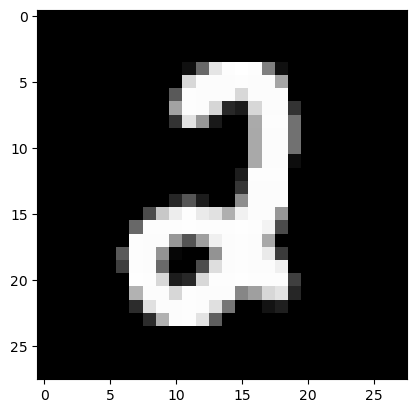

In [3]:
print('The image 70 in train data is:',y_train[70])
plt.imshow(x_train[70].reshape(28,28), cmap='gray')

# We Define the Loss function that shall be minimized: 

In [4]:
def loss_function(W,x,y,alpha):
    value = 0
    for i in range(x.shape[0]):
        v1 = 0
        v2 = 0
        for j in range(y.shape[1]):
            v1 += np.exp(x[i,:]@W[:,j])
            v2 += y[i,j]*(x[i,:]@W[:,j])
        value += np.log(v1) - v2
    value/= x.shape[0]
    value += alpha/2 * norm(W,2)**2

    return value

# One hot Encoding for Labels 

To obtain a matrix for each image per label, we have done the one-hot-encoding that returns a vector of zeros and 1 on the true label.

In [5]:
#Encoding the x_train labels
y_train_encoded = OneHotEncoder()
y_train_encoded = y_train_encoded.fit_transform(y_train.reshape(-1,1))

#encoding the validation labels 
y_validate_encoded = OneHotEncoder()
y_validate_encoded = y_validate_encoded.fit_transform(y_validate.reshape(-1,1))

#encoding the test labels
y_test_encoded = OneHotEncoder()
y_test_encoded = y_test_encoded.fit_transform(y_test.reshape(-1,1))

### we compute the gradient manually in the beginning  
$\forall i \in \{1, \dots \dots, n\}$
 The gradient of $F_i$ respect to $w_{t,p} ~ \forall t \in \{1, \dots \dots, d\} ~ \& ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{t, p}} F_i = x_{i,t}\frac{\exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,p})}{\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j})} - y_{i,p}x_{i,t} + \alpha w_{t, p}$$

# Define the Gradient:

 The gradient of the whole matrix W 

In [6]:
def grad_cost_funct(W,x,y,alpha):            #x is x_train         y is y_train
    grad = np.zeros(W.shape)                 #build  a matrix with the same size of W with zeros entries 
    for k in range(grad.shape[0]):
        for j in range(grad.shape[1]):
            for i in range(x.shape[0]):
                v = 0
                for e in range(y.toarray().shape[1]):
                    v += np.exp(x[i,:]@W[:,e])          #the sum of x[i,k]*w[k,j] is the inner product between them
                    
                grad[k,j] += ((x[i,k]*np.exp(x[i,:]@W[:,j]))/v) - y.toarray()[i,j]*x[i,k]
            grad[k,j] /= x.shape[0]
            grad[k,j] += alpha*W[k,j]
    
    return grad

**The gradient of F at a specific image.**

We have done two implementations for the gradient the first one ("commented") had a very high complexity that caused a high running time but after modification we managed to obtain a one with a very low complexity, so the algorithm will run very fast.

In [14]:
#The gradient of F at a specific image.
#def grad_cost_funct_i(i,W,x,y,alpha):
#    grad = np.zeros(W.shape)
#    for k in range(grad.shape[0]):
#        for j in range(grad.shape[1]):
#            v = 0
#            for e in range(y.toarray().shape[1]):
#                v += np.exp(x[i,:]@W[:,e])  
#            grad[k,j] += ((x[i,k]*np.exp(x[i,:]@W[:,j]))/v) - y.toarray()[i,j]*x[i,k]
#            grad[k,j] /= x.shape[0]
#            grad[k,j] += alpha*W[k,j]
#    
#    return grad

def gradient_Denominator(i, W, X,y):      # i stands for the image we will randomly pick, which her accuracy will be computed per iteration
    
    D = 0                     
    E = np.zeros(y.toarray().shape[1])    # The array of the scalar product values for each label for a specific image 
    for j in range(y.toarray().shape[1]):
        E[j] = np.exp(X[i,:]@ W[:,j])     # Computing E_p for each p = 0,....,9
        D += E[j]                         # Computing the denominator of the gradient 
    
    return E, D

def grad_cost_funct_i(i, W, X,y, alpha):
    
    G_W = np.zeros((X.shape[1] ,y.toarray().shape[1]))                      # The gradient of F_i w.r.t. w  

    E, D = gradient_Denominator(i, W, X,y)                                  # Computing D and E_j 
    for j in range(y_train_encoded.shape[1]):
        G_W[:,j] = X[i,:]*(E[j]/D) - y.toarray()[i,j]*X[i,:] + alpha*W[:,j] # Computing the gradient w.r.t. w    
    return (G_W)                                                            # Return the gradient of W for specific i

**Example**

In [15]:
W0 = np.random.normal(0, 1, size=(784,10))
b = grad_cost_funct_i(90,W0,x_train,y_train_encoded,1)
print(b)

[[-6.34662974e-01  1.42100981e+00 -1.62002386e+00 ...  4.62048637e-02
   7.86085943e-01  2.29210828e-01]
 [-3.58565671e-01  6.28233480e-01 -1.39907049e+00 ...  1.58563488e-01
   4.34487965e-01 -7.76307340e-01]
 [ 1.42436730e+00  5.88192428e-01  2.88829808e-01 ... -3.57555390e-01
  -7.62439720e-01 -2.19944071e+00]
 ...
 [ 2.67823176e-04 -7.52667031e-01  1.02095579e+00 ... -4.10435305e-01
   1.32730783e-01 -6.39023393e-01]
 [ 1.67431017e+00 -5.96313586e-01  6.97118749e-02 ... -1.97751631e+00
   7.13123810e-02 -4.17100965e-01]
 [ 1.14015801e+00 -6.83517478e-01 -1.54980774e+00 ... -1.40797988e+00
   7.48664234e-01 -1.63159529e+00]]


### Recall Stochastic Gradient Algorithm 
***
Given a sequence of determenistic step sizes $\gamma_k$, and $x_0 \in \mathbb{R}^d$, the algorithm reads:- 
$$x_{k+1} = x_k - \gamma_k \nabla f(x_k, \xi_{k+1})$$
***
**Thus,** in our case:- 
$$ w_{k+1} = w_{k} - \gamma_k \nabla F_i(w_k)$$

* Since $F$ is convex, we can benefit of the step size sequences studied during the course, we have two cases:- 
\begin{cases}
\gamma_k = \frac{a}{\sqrt{K}} & \text{if the number of iterations is known=K} \\
\gamma_k = \frac{\gamma_0}{\sqrt{k + 1}} & \text{Otherwise} 
\end{cases}

*we used two stopping criterias : 
1. the first one was the number of iterations and in this case we put $\gamma_k = \frac{a}{\sqrt{K}}$ 
2. but when we used the the norm of the difference of sequentially x's as a stopping criteria we put $\gamma_k = \frac{\gamma_0}{\sqrt{k + 1}} $

# Stochastic Gradient Descent Implemenation

 It worth mentioning that a benefit of stochastic gradient descent is that, since it is stochastic, it can avoid getting stuck in a suboptimal region. but first we define the random samplw we will draw 

In [16]:
# We define a distribution for I to be uniform
def sample():             #we draw a sample
    numbers = range(x_train.shape[0])              #dimension of x_train = n_train * pixles ==> x_train.shape[0]=n_train (54000)
    distributions = np.ones(len(numbers))* (1/len(numbers))     #probabilities of uniform distribution
    random_number = np.random.choice(numbers, 1, True, distributions)  

    return random_number[0]

We define the SGD algorithm with a known number of iterations

In [20]:
def Stochastic_Gradient_descent_with_iterate(W0,n_iter,gamma0,alpha,x,y):
    iterations = []
    accuracy = []
    values = []
    W = W0
    k=0
    start = time.time()
    print('Progression {}%'.format(0),end = '\r',flush = True)
    print('starting the SGD Algorithm with {} iterations at alpha = {} ===>'.format(n_iter,alpha))
    print('Iteration | Accuracy')
    print('--------------------')
    while k < n_iter:
        k += 1
        print('Progression {}%'.format(k*100/n_iter),end = '\r',flush = True)
        i= sample()
        W -= (gamma0/np.sqrt(n_iter)) * grad_cost_funct_i(i,W,x,y,alpha)
        
        #here we want to reveal the accuracy and objective value at specific iterations
        if k % 1000 == 0:
            iterations.append(k)
            values.append(W)
            accuracy.append(Accuracy(W))
            print('    {}    |     {}'.format(k,Accuracy(W)))
            print('--------------------')
    end = time.time()
    print("The time needed:", end-start)
    return W , iterations, accuracy, values

We try to define the algorithm with another stopping criteria where the second norm of the difference between two consecutive values for W should be less than a specific tolerence.

In [21]:
def Stochastic_Gradient_descent_with_norm(W0,epsilon,gamma0,alpha,x,y):
    W = W0
    values = [np.zeros(W.shape),W]
    start = time.time()
    k = 0
    print('starting the SDG Algorithm with stopping criteria at alpha = {}: ===>'.format(alpha))
    while norm(values[-1]-values[-2],2) > epsilon:
        k +=1
        i= sample()
        W -= (gamma0/np.sqrt(k+1)) * grad_cost_funct_i(i,W,x,y,alpha)
        values.append(W)
    end = time.time()
    print("The time needed:", end-start)
    print('Number of Iterations Needed to have ||W_k+1 - W_k|| < {}  is: {} with accuracy: {}'.format(epsilon,k,Accuracy(W)))
    return W

# The accuracy of the model

In [22]:
def Accuracy(W_alpha):
    v=0
    for i in range(x_validate.shape[0]):
        v += (np.argmax(x_validate[i]@W_alpha)==np.argmax(y_validate_encoded.toarray()[i]))*1   
        # *1 to convert boolean to numeric
    v /= x_validate.shape[0]
    return v

**Here we want to make a table that represents the number of iterations and the accuracy at these iterations , Moreover we want to reveal the progression show the progress of the model.**

# Running tests:

In [23]:
W0 = np.random.normal(0, 1, size=(784,10))
n_iter = 20000           
gamma0 = 1
alpha = 0.8

W,iterations,accuracy, values = Stochastic_Gradient_descent_with_iterate(W0,n_iter,gamma0,alpha,x_train,y_train_encoded)

starting the SGD Algorithm with 20000 iterations at alpha = 0.8 ===>
Iteration | Accuracy
--------------------
    1000    |     0.6413333333333333
--------------------
    2000    |     0.6928333333333333
--------------------
    3000    |     0.5866666666666667
--------------------
    4000    |     0.6733333333333333
--------------------
    5000    |     0.5848333333333333
--------------------
    6000    |     0.539
--------------------
    7000    |     0.5928333333333333
--------------------
    8000    |     0.6256666666666667
--------------------
    9000    |     0.6881666666666667
--------------------
    10000    |     0.5673333333333334
--------------------
    11000    |     0.6603333333333333
--------------------
    12000    |     0.657
--------------------
    13000    |     0.703
--------------------
    14000    |     0.6101666666666666
--------------------
    15000    |     0.7076666666666667
--------------------
    16000    |     0.651
--------------------
    17

In [24]:
W0 = np.random.normal(0, 1, size=(784,10))
epsilon = 0.09
gamma0 = 2
alpha = 1

W_criteria = Stochastic_Gradient_descent_with_norm(W0,epsilon,gamma0,alpha,x_train,y_train_encoded)

starting the SDG Algorithm with stopping criteria at alpha = 1: ===>
The time needed: 0.05704927444458008
Number of Iterations Needed to have ||W_k+1 - W_k|| < 0.09  is: 1 with accuracy: 0.10616666666666667


# With the Best Alpha:

In [26]:
# we define SGD with no accuracy and values to be faster. (we now focus on the last accuracy)
def Stochastic_Gradient_descent_withiterate_tune_alpha(W0,n_iter,gamma0,alpha,x,y):
    W = W0
    k=0
    start = time.time()
    print('Progression {}%'.format(0),end = '\r',flush = True)
    print('starting the SDG Algorithm with {} iterations at alpha = {} ==================>'.format(n_iter,alpha))
    print('Iteration | Accuracy')
    print('--------------------')
    while k < n_iter:
        k += 1
        print('Progression {}%'.format(k*100/n_iter),end = '\r',flush = True)
        i= sample()
        W -= (gamma0/np.sqrt(n_iter)) * grad_cost_funct_i(i,W,x,y,alpha)
    
    print('    {}    |     {}'.format(k,Accuracy(W)))
    print('--------------------')
    end = time.time()
    print("The time needed:", end-start)
    return W 

# creaste a list of 11 elements to define values for Alpha starting from 10 and divide by two
Alpha = [10]
for i in range(10):
    Alpha.append(Alpha[i]/2)

#Define the parameters to pass in
W0 = np.random.normal(0, 1, size=(784,10))
n_iter = 20000
gamma0 = 1

#create an array containing W values of each alpha & array for accuracy.
Parameter = []
Accuracy_with_alpha = []
for i in Alpha:
    W = Stochastic_Gradient_descent_withiterate_tune_alpha(W0,n_iter,gamma0,i,x_train,y_train_encoded)
    Parameter.append(W)
    Accuracy_with_alpha.append(Accuracy(W))

starting the SDG Algorithm with 20000 iterations at alpha = 10 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.16933333333333334
--------------------
The time needed: 387.0958149433136
starting the SDG Algorithm with 20000 iterations at alpha = 5.0 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.289
--------------------
The time needed: 313.38022351264954
starting the SDG Algorithm with 20000 iterations at alpha = 2.5 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.44266666666666665
--------------------
The time needed: 255.32383394241333
starting the SDG Algorithm with 20000 iterations at alpha = 1.25 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.5061666666666667
--------------------
The time needed: 260.4297311306
starting the SDG Algorithm with 20000 iterations at alpha = 0.625 ==================>
Iteration | Accuracy
--------------------
    

# Now ADAM


# The algorithm : 
$\alpha_k = \dfrac{\alpha_0}{\sqrt{k+1}}$ 

$m_{k+1} = \beta_1 m_k + (1-\beta_1) \nabla f(x_k,\xi_{k+1}) $

$\hat{m}_{k+1} = \dfrac{m_{k+1}}{1-\beta{_1}^{k+1}}$

$v_{k+1} = \beta_2 v_k + (1-\beta_2) \nabla f(x_k,\xi_{k+1})^2 $

$\hat{v}_{k+1} = \max (\hat{v}_k , \dfrac{v_{k+1}}{1-\beta{_2}^{k+1}} )$

$x_{k+1} = x_k - \dfrac{\alpha_k}{\epsilon + \sqrt{ \hat{v}_{k+1}}}\hat{m}_{k+1}$

As we learnt in  the class Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

The main ingredients of this algorithm are : 

*     adaptive estimation of the first and second moments of the SGD.
*     coordinate-wise step-sizes.



**The idea is to design an exponential moving average of previous gradients and square gradients as an estimation of it's moments (The first and the second).**

#### The parameters of Adam algorithm are :

*  $\alpha >0 $ 
*  $\beta_1 \in [0,1] $
*  $\beta_2 \in [0,1]$ **with** $\beta_1 ^2 < \beta_2 < 1$
*  $\epsilon >0 $ 


In [27]:
def adam(W0, n_iter, step0, beta1, beta2, epsilon, alpha, x, y): #Alpha is the step
    values = []
    iterations = []
    accuracy = []
    W = W0
    n_features = (784,10)
    #initialize m_0 = 0
    accumulated_gradient = np.zeros(n_features)    #m_k
    
    #initialize v_0 = 0
    accumulated_square_gradient = np.zeros(n_features)       #v_k
    start = time.time()
    print('Progression {}%'.format(0),end = '\r',flush = True)
    print('starting the ADAM Algorithm with {} iterations at alpha = {} ==================>'.format(n_iter,alpha))
    print('Iteration | Accuracy')
    print('--------------------')
    for k in range(1,n_iter + 1):
        print('Progression {}%'.format(k*100/n_iter),end = '\r',flush = True)
        i = sample()
        step = step0/np.sqrt(k+1)                                                 # αk = α0/√(k+1) 
        gradient = grad_cost_funct_i(i,W,x,y,alpha)                               
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient    #m_k+1
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))     #m^hat_k+1
        accumulated_square_gradient = beta2*accumulated_square_gradient + (1-beta2) *(gradient)**2  #v_k+1
        
        # Here there is no need to define v^hat_k+1 = max(v^hat_k,(v_k+1 / 1-beta_2^{k+1}))
        #because we proved in the class that the maximum between them is equal to (v_k+1 / 1-beta_2^{k+1}), so i put it directly.
        accumulated_square_gradient_correction = accumulated_square_gradient/(1 - beta2**(k+1))      #v^hat_k+1 
        
        W -=  (step /(np.sqrt(accumulated_square_gradient_correction) + epsilon))*accumulated_gradient_correction
        if k % 1000 == 0:
            values.append(W)
            iterations.append(k)
            accuracy.append(Accuracy(W))
            print('    {}    |     {}'.format(k,Accuracy(W)))
            print('--------------------')
    end = time.time()
    print("The time needed:", end-start)
    return W , iterations, accuracy, values

# Running Test:

In [28]:
W0 = np.random.normal(0, 1, size=(784,10))
n_iter = 20000   # Number of iterations for the algorithm 
alpha = 0.8
epsilon = 0.2
beta1 = 0.4
beta2 = 0.7
step0 = 1

W_adam, iterations_adam , accuracy_adam, values_adam=adam(W0, n_iter, step0, beta1, beta2, epsilon, alpha, x_train, y_train_encoded)

starting the ADAM Algorithm with 20000 iterations at alpha = 0.8 ==================>
Iteration | Accuracy
--------------------
    1000    |     0.19166666666666668
--------------------
    2000    |     0.21166666666666667
--------------------
    3000    |     0.21366666666666667
--------------------
    4000    |     0.3333333333333333
--------------------
    5000    |     0.455
--------------------
    6000    |     0.45
--------------------
    7000    |     0.405
--------------------
    8000    |     0.3155
--------------------
    9000    |     0.2715
--------------------
    10000    |     0.4583333333333333
--------------------
    11000    |     0.4493333333333333
--------------------
    12000    |     0.36283333333333334
--------------------
    13000    |     0.4221666666666667
--------------------
    14000    |     0.36033333333333334
--------------------
    15000    |     0.486
--------------------
    16000    |     0.41683333333333333
--------------------
    17000

# With the Best Alpha:

In [31]:
def ADAM_tune_alpha(W0,n_iter,step0, beta1, beta2, epsilon,alpha,x,y):
    n_features = (784,10)
    W =W0
    accumulated_gradient = np.zeros(n_features)    #m_k
    accumulated_square_gradient = np.zeros(n_features)       #v_k
    start = time.time()
    print('Progression {}%'.format(0),end = '\r',flush = True)
    print('starting the ADAM Algorithm with {} iterations at alpha = {} ==================>'.format(n_iter,alpha))
    print('Iteration | Accuracy')
    print('--------------------')
    for k in range(1,n_iter + 1):
        print('Progression {}%'.format(k*100/n_iter),end = '\r',flush = True)
        i = sample()
        step = step0/np.sqrt(k+1)
        gradient = grad_cost_funct_i(i,W,x,y,alpha)
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient    #m_k+1
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))     #m^hat_k+1
        accumulated_square_gradient = beta2*accumulated_square_gradient + (1-beta2) *(gradient)**2  #v_k+1
        accumulated_square_gradient_correction = accumulated_square_gradient/(1 - beta2**(k+1))      #v^hat_k+1
        W -=  (step /(np.sqrt(accumulated_square_gradient_correction) + epsilon))*accumulated_gradient_correction
    print('    {}    |     {}'.format(k,Accuracy(W)))
    print('--------------------')
    end = time.time()
    print("The time needed:", end-start)
    return W

Alpha = [10]
for i in range(10):
    Alpha.append(Alpha[i]/2)

W0 = np.random.normal(0, 1, size=(784,10))
n_iter = 20000
epsilon = 0.2
beta1 = 0.4
beta2 = 0.7
step0 = 1

Parameter_adam = []
Accuracy_with_alpha_adam = []
for i in Alpha:
    W = ADAM_tune_alpha(W0,n_iter,step0, beta1, beta2, epsilon,i,x_train,y_train_encoded)
    Parameter_adam.append(W)
    Accuracy_with_alpha_adam.append(Accuracy(W))

starting the ADAM Algorithm with 20000 iterations at alpha = 10 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.1395
--------------------
The time needed: 260.9350621700287
starting the ADAM Algorithm with 20000 iterations at alpha = 5.0 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.20266666666666666
--------------------
The time needed: 258.28728199005127
starting the ADAM Algorithm with 20000 iterations at alpha = 2.5 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.229
--------------------
The time needed: 256.6960999965668
starting the ADAM Algorithm with 20000 iterations at alpha = 1.25 ==================>
Iteration | Accuracy
--------------------
    20000    |     0.24316666666666667
--------------------
The time needed: 258.23921632766724
starting the ADAM Algorithm with 20000 iterations at alpha = 0.625 ==================>
Iteration | Accuracy
--------------------
    2000

# Now we present some nice plots

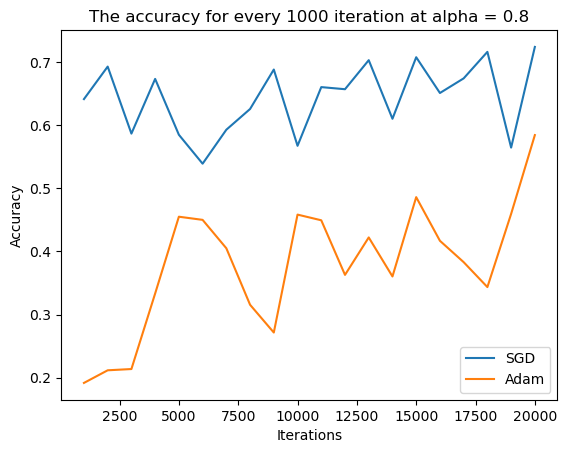

In [37]:
plt.plot(iterations, accuracy, label = 'SGD')
plt.plot(iterations, accuracy_adam , label = 'Adam')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('The accuracy for every 1000 iteration at alpha = 0.8')
plt.legend()
plt.show()

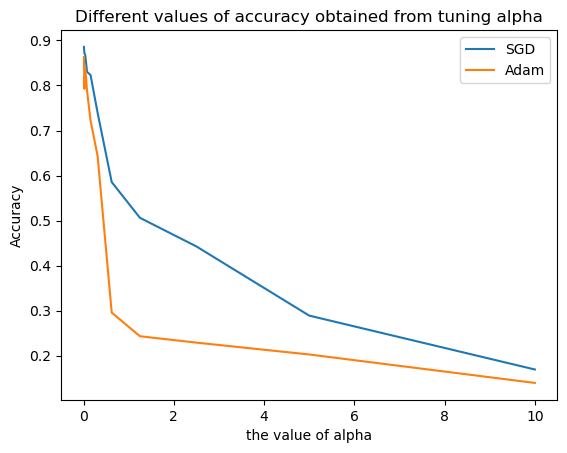

In [39]:
plt.plot(Alpha, Accuracy_with_alpha, label = 'SGD')
plt.plot(Alpha, Accuracy_with_alpha_adam , label = 'Adam')
plt.xlabel('the value of alpha')
plt.ylabel('Accuracy')
plt.title('Different values of accuracy obtained from tuning alpha')
plt.legend()
plt.show()

# Finally the accuracy at test data:

In [41]:
def Accuracy_test(W_alpha):
    v=0
    for i in range(x_test.shape[0]):
        v += (np.argmax(x_test[i]@W_alpha)==np.argmax(y_test_encoded.toarray()[i]))*1   
        # *1 to convert boolean to numeric
    v /= x_test.shape[0]
    return v
SGD_accuracy_on_test = Accuracy_test(Parameter[np.argmax(Accuracy_with_alpha)])
ADAM_accuracy_on_test = Accuracy_test(Parameter_adam[np.argmax(Accuracy_with_alpha_adam)])
print('The accuracy on test data using SGD with W obtained from alpha = {} is {}'.format(Alpha[np.argmax(Accuracy_with_alpha)],SGD_accuracy_on_test))
print('The accuracy on test data using ADAM with W obtained from alpha = {} is {}'.format(Alpha[np.argmax(Accuracy_with_alpha_adam)],ADAM_accuracy_on_test))

The accuracy on test data using SGD with W obtained from alpha = 0.009765625 is 0.8983
The accuracy on test data using ADAM with W obtained from alpha = 0.009765625 is 0.8733


# Example using the trained model:

A test using W obtained from SGD:


True number :  1

Predicted number :  1



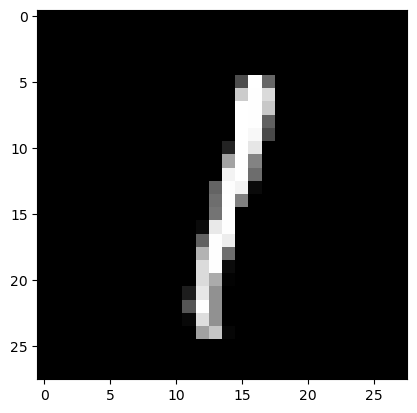

In [66]:
i=57
y_predict=x_test[i]@Parameter[np.argmax(Accuracy_with_alpha)]
print("\nTrue number : ",y_test[i])
print("\nPredicted number : ",np.argmax(y_predict))
print()
plt.imshow(x_test[i].reshape(28,28), cmap='gray')

A Test using W obtained from ADAM


True number :  9

Predicted number :  9



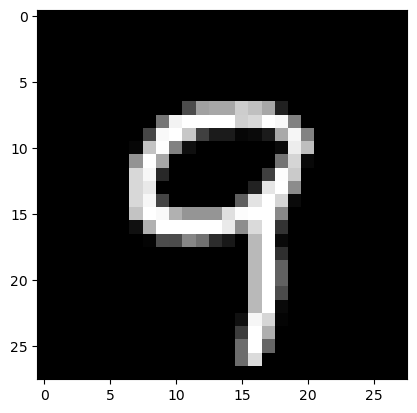

In [71]:
i=105
y_predict=x_test[i]@Parameter[np.argmax(Accuracy_with_alpha_adam)]
print("\nTrue number : ",y_test[i])
print("\nPredicted number : ",np.argmax(y_predict))
print()
plt.imshow(x_test[i].reshape(28,28), cmap='gray')